In [32]:
import os
import pandas as pd
import numpy as np
import re
from ppmusa import load_eia_data

### Load EIA Data

In [33]:
eia_data_operable, eia_storage, eia_loc, eia_plants_locs = load_eia_data(filter_region= "WECC",base_dir = '../..')

Goal is to have only ADS referenced generators in the network. Only need for EIA database is the locations

### Load ADS Generator List, Thermal General Info, and IOCurves.
Merge tables on various IDS

In [34]:
ADS_PATH = os.path.join('../../data/WECC_ADS/downloads/2032/Public Data')
ads_thermal= pd.read_csv(ADS_PATH + '/Thermal_General_Info.csv',skiprows=1, )#encoding='unicode_escape')
ads_thermal = ads_thermal[['GeneratorName', ' Turbine Type', 'Model Type', 'MustRun',
       'MinimumDownTime(hr)', 'MinimumUpTime(hr)', 'MaxUpTime(hr)',
       'Generic Ramp Rate Name', 'RampUp Rate(MW/minute)',
       'RampDn Rate(MW/minute)', 'Startup Cost Fixed($)', 'StartFuel(MMBTu)', 'Startup Time',
       'VOM Cost']]

# Combine IOC data with the General Thermal Plant Data
ads_ioc= pd.read_csv(ADS_PATH + '/Thermal_IOCurve_Info.csv',skiprows=1, ).rename(columns={'Generator Name':'GeneratorName'})
ads_ioc = ads_ioc[[
       'GeneratorName', 'IOMaxCap(MW)','IOMinCap(MW)', 'MinInput(MMBTu)', 
       'IncCap2(MW)','IncHR2(MMBTu/MWh)','IncCap3(MW)', 'IncHR3(MMBTu/MWh)', 
       'IncCap4(MW)','IncHR4(MMBTu/MWh)','IncCap5(MW)', 'IncHR5(MMBTu/MWh)',
       'IncCap6(MW)','IncHR6(MMBTu/MWh)','IncCap7(MW)', 'IncHR7(MMBTu/MWh)']]

#Replacing heat rates with 0 with NaN
ads_ioc['IncHR2(MMBTu/MWh)'] = ads_ioc['IncHR2(MMBTu/MWh)'].replace(0, np.nan)

print('Size of thermal generator data: ', ads_thermal.shape)
print('Size of IOC generator data: ', ads_ioc.shape)
thermal_plant_data = pd.merge(ads_thermal, ads_ioc, on='GeneratorName', how='left')
thermal_plant_data

Size of thermal generator data:  (1508, 14)
Size of IOC generator data:  (1506, 16)


,GeneratorName,Turbine Type,Model Type,MustRun,MinimumDownTime(hr),MinimumUpTime(hr),MaxUpTime(hr),Generic Ramp Rate Name,RampUp Rate(MW/minute),RampDn Rate(MW/minute),...,IncCap3(MW),IncHR3(MMBTu/MWh),IncCap4(MW),IncHR4(MMBTu/MWh),IncCap5(MW),IncHR5(MMBTu/MWh),IncCap6(MW),IncHR6(MMBTu/MWh),IncCap7(MW),IncHR7(MMBTu/MWh)
0,Copper_1,GT,NaN,False,1,1,-1,NaN,6.40,6.40,...,38.667,11.047,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
1,Montana_4_G4,GT LMS_LMS100,NaN,False,1,1,-1,NaN,80.28,80.28,...,31.333,7.315,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
2,Montana_3_G3,GT LMS_LMS100,NaN,False,1,1,-1,NaN,80.28,80.28,...,31.333,7.365,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
3,Montana_2_G2,GT LMS_LMS100,NaN,False,1,1,-1,NaN,79.38,79.38,...,31.333,7.028,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
4,Montana_1_G1,GT LMS_LMS100,NaN,False,1,1,-1,NaN,79.38,79.38,...,28.800,7.218,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,Fort St Vrain 7,GT F_7FA,NaN,False,1,1,1,NaN,15.80,15.80,...,30.000,7.691,30.000,8.519,0.0,0.0,0.0,0.0,0.0,0.0
1504,Fort St Vrain 8,GT F_7FA,NaN,False,1,1,1,NaN,15.80,15.80,...,30.000,7.691,30.000,8.519,0.0,0.0,0.0,0.0,0.0,0.0
1505,Fort St Vrain 9,GT F_7FA,NaN,False,1,1,1,NaN,15.80,15.80,...,30.000,7.691,30.000,8.519,0.0,0.0,0.0,0.0,0.0,0.0
1506,Spindle Hill 1,GT F_7FA,NaN,False,1,1,1,NaN,15.40,15.40,...,26.334,7.394,26.333,7.785,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
#loading ads to match ads_name with generator key in order to link with ads thermal file
ads= pd.read_csv(ADS_PATH + '/GeneratorList.csv',skiprows=2, encoding='unicode_escape')
ads['Long Name'] = ads['Long Name'].astype(str)
ads.rename({'Name': 'ads_name', 'Long Name': 'ads_long_name',
             'SubType': 'subtype','Commission Date':'commission_date',
             'Retirement Date':'retirement_date','Area Name':'balancing_area'},
               axis=1, inplace=True)
ads.rename(str.lower, axis='columns', inplace=True)
ads['long id'] = ads['long id'].astype(str)
ads['tech_type'] = ads['fueltype'] + "_" + ads['technology']
ads_name_key_dict = dict(zip(ads['ads_name'], ads['generatorkey']))
print('Size of ads data: ', ads.shape)


# # Merge ads data with renewable plant data
cols = ['GeneratorKey', 'GeneratorName', 'Type',
       'DispatchShapeName', 'DispatchMultiplier', 'Capacity(MW)',
       ]
ads_hourly = pd.read_csv(ADS_PATH + '/HourlyResource_General.csv', skiprows=2,  encoding='unicode_escape')[cols]
ads_hourly.rename(columns={'Capacity(MW)': 'capacity_hourly_rsc'}, inplace=True)
# # Check if DispatchMultiplier is within 10 of Capacity(MW)
# tolerance = 100
# diff = abs(ads_hourly['DispatchMultiplier'] - ads_hourly['Capacity(MW)'])
# within_tolerance = (diff <= tolerance)
# ads_hourly[~within_tolerance]
ads = pd.merge(ads,ads_hourly.drop_duplicates(subset=['GeneratorName']), left_on='ads_name', right_on='GeneratorName', how='left')
print("Size of ads data: ", ads.shape)

Size of ads data:  (5035, 31)
Size of ads data:  (5035, 37)


In [36]:
ads_thermal = pd.merge(ads, thermal_plant_data, left_on='ads_name', right_on='GeneratorName', how='left')

In [37]:
eia_ads_mapping = pd.read_csv('../../repo_data/eia_mappings/eia_ads_generator_mapping_updated.csv')
cols = ['generatorkey', 'plant_id_eia', 'lat', 'lon']
ads_thermal_locs = pd.merge(ads_thermal, eia_ads_mapping[cols], on= 'generatorkey', how='inner')
print("Percent of Plant Locations Matched: ", round(100*ads_thermal_locs.shape[0]/ads_thermal.shape[0], 2), "%")
print("Percent of Capacity Matched: ", round(100*ads_thermal_locs['maxcap(mw)'].sum()/ads_thermal['maxcap(mw)'].sum(), 2), "%")
ads_thermal_locs

Percent of Plant Locations Matched:  56.07 %
Percent of Capacity Matched:  55.87 %


,generatorkey,ads_name,bus id,bus name,bus kv,unit id,generator typeid,subtype,long id,ads_long_name,...,IncHR4(MMBTu/MWh),IncCap5(MW),IncHR5(MMBTu/MWh),IncCap6(MW),IncHR6(MMBTu/MWh),IncCap7(MW),IncHR7(MMBTu/MWh),plant_id_eia,lat,lon
0,40,Hatch_Solar_EC,11404,HAT_DIST_PV,0.69,'PV,4,SolarPV-Tracking,NM-57591-1,"Hatch Solar Energy Center I, LLC-1",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57591.0,32.630000,-107.259700
1,45,Copper_1,11051,COPPER_G,13.80,'1,1,CT-NatGas-Industrial,TX-9-1,Copper-1,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,31.756900,-106.375000
2,54,Montana_4_G4,11233,MPS4,13.80,'1,1,CT-NatGas-Aero,TX-58562-GT-4,Montana 4-G4,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,31.823889,-106.211944
3,55,Montana_3_G3,11232,MPS3,13.80,'1,1,CT-NatGas-Aero,TX-58562-GT-3,Montana 3-G3,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,31.823889,-106.211944
4,56,Montana_2_G2,11228,MPS2,13.80,'1,1,CT-NatGas-Aero,TX-58562-GT-2,Montana 2-G2,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,31.823889,-106.211944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20636,Niyol Wind,72739,NIYOL_GEN,0.63,'W,4,WT-Onshore,CO-65059-WNIYO,"Niyol Wind, LLC",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65059.0,40.613364,-102.952600
2819,20640,Spindle Hill 1,70593,SPNDLE1,18.00,'G1,1,CT-NatGas-Industrial,CO-56445-GEN1,Spindle Hill Energy Center GEN1,...,7.785,0.0,0.0,0.0,0.0,0.0,0.0,56445.0,40.092192,-104.887800
2820,20641,Spindle Hill 2,70594,SPNDLE2,18.00,'G2,1,CT-NatGas-Industrial,CO-56445-GEN2,Spindle Hill Energy Center GEN2,...,8.414,0.0,0.0,0.0,0.0,0.0,0.0,56445.0,40.092192,-104.887800
2821,20642,Opal Springs,45368,OPAL,69.00,'N,2,Hydro,OR-54251-1,Deschutes Valley Water District (Opal Springs)...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54251.0,44.490040,-121.298800


In [38]:
#Assign locations to the Buses which we know the location of from other matches
bus_name_locs = ads_thermal_locs[['bus name', 'lat', 'lon']].groupby(['bus name']).mean().reset_index()
ads_unmatched = ads_thermal[~ads_thermal['generatorkey'].isin(ads_thermal_locs['generatorkey'])]
ads_unmatched_buses_known = ads_unmatched[ads_unmatched['bus name'].isin(bus_name_locs['bus name'])]
ads_unmatched_buses_known['lat'] = ads_unmatched_buses_known['bus name'].map(bus_name_locs.set_index('bus name')['lat'])
ads_unmatched_buses_known['lon'] = ads_unmatched_buses_known['bus name'].map(bus_name_locs.set_index('bus name')['lon'])
ads_unmatched_buses_known
ads_thermal_locs = pd.concat([ads_thermal_locs, ads_unmatched_buses_known])
print("Percent of plants located: ", round(100*len(ads_thermal_locs)/len(ads_thermal),2), "%")
print("Percent of Capacity Matched: ", round(100*ads_thermal_locs['maxcap(mw)'].sum()/ads_thermal['maxcap(mw)'].sum(), 2), "%")
ads_thermal_locs


Percent of plants located:  63.79 %
Percent of Capacity Matched:  69.05 %


/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/ipykernel_44314/1688469837.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ads_unmatched_buses_known['lat'] = ads_unmatched_buses_known['bus name'].map(bus_name_locs.set_index('bus name')['lat'])
/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/ipykernel_44314/1688469837.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ads_unmatched_buses_known['lon'] = ads_unmatched_buses_known['bus name'].map(bus_name_locs.set_index('bus name')['lon'])


,generatorkey,ads_name,bus id,bus name,bus kv,unit id,generator typeid,subtype,long id,ads_long_name,...,IncHR4(MMBTu/MWh),IncCap5(MW),IncHR5(MMBTu/MWh),IncCap6(MW),IncHR6(MMBTu/MWh),IncCap7(MW),IncHR7(MMBTu/MWh),plant_id_eia,lat,lon
0,40,Hatch_Solar_EC,11404,HAT_DIST_PV,0.69,'PV,4,SolarPV-Tracking,NM-57591-1,"Hatch Solar Energy Center I, LLC-1",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57591.0,32.630000,-107.259700
1,45,Copper_1,11051,COPPER_G,13.80,'1,1,CT-NatGas-Industrial,TX-9-1,Copper-1,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,31.756900,-106.375000
2,54,Montana_4_G4,11233,MPS4,13.80,'1,1,CT-NatGas-Aero,TX-58562-GT-4,Montana 4-G4,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,31.823889,-106.211944
3,55,Montana_3_G3,11232,MPS3,13.80,'1,1,CT-NatGas-Aero,TX-58562-GT-3,Montana 3-G3,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,31.823889,-106.211944
4,56,Montana_2_G2,11228,MPS2,13.80,'1,1,CT-NatGas-Aero,TX-58562-GT-2,Montana 2-G2,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,31.823889,-106.211944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5017,20627,Piceance Creek Solar Phase I,79014,CRAIG,345.00,'X4,4,SolarPV-Tracking,_,Piceance Creek Solar Phase I (Bar D)1PV-T4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.665830,-103.132400
5024,20634,Fresno Peaker,34608,AGRICO,13.80,'3,1,CT-NatGas-Aero,CA-,Fresno Peaker,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,36.617022,-120.099800
5027,20637,Fort St Vrain 7,70950,ST.VR_5,18.00,'X0,1,CT-NatGas-Industrial,CO-,Generic_GT,...,8.519,0.0,0.0,0.0,0.0,0.0,0.0,NaN,40.246100,-104.874200
5028,20638,Fort St Vrain 8,70951,ST.VR_6,18.00,'X0,1,CT-NatGas-Industrial,CO-,Generic_GT,...,8.519,0.0,0.0,0.0,0.0,0.0,0.0,NaN,40.246100,-104.874200


In [39]:
ads_non_usa

,generatorkey,ads_name,bus id,bus name,bus kv,unit id,generator typeid,subtype,long id,ads_long_name,...,IncCap4(MW),IncHR4(MMBTu/MWh),IncCap5(MW),IncHR5(MMBTu/MWh),IncCap6(MW),IncHR6(MMBTu/MWh),IncCap7(MW),IncHR7(MMBTu/MWh),lat,lon
7,412,PdteJuarezGT1,20012,TTI-U1,13.8,'1,1,CT-NatGas-Industrial,MX-N/A-N/A,Pdte.Juarez GT-1,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,31.85437,-115.90479
8,413,PdteJuarezGT2,20013,TTI-U2,13.8,'2,1,CT-NatGas-Industrial,MX-N/A-N/A,Pdte.Juarez GT-2,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,31.85437,-115.90479
9,414,Mexicali1,20156,MXI-U1,13.8,'1,1,ICE-OilDistillate,MX-N/A-N/A,Mexicali-1,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,31.85437,-115.90479
10,415,Mexicali2,20231,MXI-U2,13.8,'2,1,ICE-OilDistillate,MX-N/A-N/A,Mexicali-2,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,31.85437,-115.90479
11,416,Mexicali3,20232,MXI-U3,13.8,'3,1,ICE-OilDistillate,MX-N/A-N/A,Mexicali-3,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,31.85437,-115.90479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5008,20616,Battle River 4 Gas,55496,BAT #4,16.0,'4,1,ST-NatGas,AB-N/A-N/A,Battle River 4 Gas,...,27.0,10.923,0.0,0.0,0.0,0.0,0.0,0.0,53.54610,-113.49380
5010,20619,Ejido San Luis CC1a,20418,ESL-01-CCG,21.0,'1,1,CCWhole-NatGas-SingleShaft,nan,Ciclo Combinado Ejido San Luis 1a,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,31.85437,-115.90479
5011,20620,GCC CC1a,20606,GCC-U1-CCG,21.0,'1,1,CCWhole-NatGas-Industrial,nan,GCC combined cycle total 1a,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,31.85437,-115.90479
5012,20621,Ejido San Luis CC1b,20422,ESL-02-CCG,21.0,'2,1,CCWhole-NatGas-SingleShaft,nan,Ciclo Combinado Ejido San Luis 1b,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,31.85437,-115.90479


In [40]:
# Concat the Non-US Plants which we know location of external bus
ads_unmatched = ads_thermal[~ads_thermal['generatorkey'].isin(ads_thermal_locs['generatorkey'])]
BA_known = ['AESO', 'BCHA', 'CFE']
ads_non_usa = ads_unmatched[ads_unmatched['balancing_area'].isin(BA_known)]

#Set Location of the external Buses
ads_non_usa['lat'] = ads_non_usa['balancing_area'].map({'AESO': 53.5461, 'BCHA': 49.2827, 'CFE': 31.85437})
ads_non_usa['lon'] = ads_non_usa['balancing_area'].map({'AESO': -113.4938, 'BCHA': -123.1207, 'CFE': -115.90479})

# Concat the Non-US Plants which we know location of external bus
ads_thermal_locs = pd.concat([ads_thermal_locs, ads_non_usa])
print("Precent of plants in known balancing areas: ", round(100*len(ads_non_usa)/len(ads_thermal),2), "%")
print("Percent of plants with Locs: ", round(100*len(ads_thermal_locs)/len(ads_thermal),2), "%")
print("Percent of plant Capacity: ", round(100*ads_thermal_locs['maxcap(mw)'].sum()/ads_thermal['maxcap(mw)'].sum(), 2), "%")

Precent of plants in known balancing areas:  14.1 %
Percent of plants with Locs:  77.89 %
Percent of plant Capacity:  81.45 %


/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/ipykernel_44314/1199853335.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ads_non_usa['lat'] = ads_non_usa['balancing_area'].map({'AESO': 53.5461, 'BCHA': 49.2827, 'CFE': 31.85437})
/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/ipykernel_44314/1199853335.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ads_non_usa['lon'] = ads_non_usa['balancing_area'].map({'AESO': -113.4938, 'BCHA': -123.1207, 'CFE': -115.90479})


In [41]:
ads_thermal_locs.to_csv('ads_thermal_locs.csv', index=False)

In [42]:
ads_unmatched = ads_thermal[~ads_thermal['generatorkey'].isin(ads_thermal_locs['generatorkey'])]
ads_unmatched = ads_unmatched.sort_values(by='maxcap(mw)', ascending=False)
ads_unmatched.to_csv('ads_unmatched.csv', index=False)
ads_unmatched

,generatorkey,ads_name,bus id,bus name,bus kv,unit id,generator typeid,subtype,long id,ads_long_name,...,IncCap3(MW),IncHR3(MMBTu/MWh),IncCap4(MW),IncHR4(MMBTu/MWh),IncCap5(MW),IncHR5(MMBTu/MWh),IncCap6(MW),IncHR6(MMBTu/MWh),IncCap7(MW),IncHR7(MMBTu/MWh)
4404,18746,DG-BTM_CISC_CA_Los Angeles,24028,DELAMO,66.00,'J8,4,DG-BTM,G0--,DG-BTM_CISC_CA_Los Angeles,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4269,18611,DG-BTM_AZPS_AZ_Maricopa,85439,FLORES,12.50,'X3,4,DG-BTM,G0--,DG-BTM_AZPS_AZ_Maricopa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4408,18750,DG-BTM_CISC_CA_San Bernardino,25688,ROADWAY 12,12.47,'J4,4,DG-BTM,G0--,DG-BTM_CISC_CA_San Bernardino,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3476,17740,Battery (Generic)BA1645.24,25559,RP_WW230_2G,0.55,'VE,3,Battery Storage,_,34.196505_-118.931898,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3518,17791,Tehachapi_Solar (Generic)PV-NT1277,25378,RP_WW_2G,0.69,'VS,4,SolarPV-NonTracking,_,Iron Point -Proposed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2542,15778,DR_PACW,44522,COLUMBIA,69.00,'DR,4,DR,nan,PACW Demand Response,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4301,18643,DG-BTM_BPAT_OR_Harney,47146,CRANE_HEC,115.00,'U1,4,DG-BTM,G0--,DG-BTM_BPAT_OR_Harney,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4292,18634,DG-BTM_BPAT_NV_Humboldt,47167,FIELDS_HEC,115.00,'V0,4,DG-BTM,G0--,DG-BTM_BPAT_NV_Humboldt,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1565,12961,DR_NEVP-1,18027,TORTISE,230.00,'DR,4,DR,NV--,NEVP Demand Response (1of8),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# from geopy.geocoders import Nominatim

# geolocator = Nominatim(user_agent="my_app")

# def get_lat_long(address):
#     location = geolocator.geocode(address)
#     if location:
#         return location.latitude, location.longitude
#     else:
#         return None


# ads_address = ads_unmatched[~ads_unmatched.county.isna()]
# addresses = ads_address.county + ", " + ads_address.state
# ads_address['lat'] = addresses.apply(lambda x: get_lat_long(x)[0] if get_lat_long(x) else None)
# ads_address['lon'] = addresses.apply(lambda x: get_lat_long(x)[1] if get_lat_long(x) else None)
# ads_address

In [44]:
ads_unmatched

,generatorkey,ads_name,bus id,bus name,bus kv,unit id,generator typeid,subtype,long id,ads_long_name,...,IncCap3(MW),IncHR3(MMBTu/MWh),IncCap4(MW),IncHR4(MMBTu/MWh),IncCap5(MW),IncHR5(MMBTu/MWh),IncCap6(MW),IncHR6(MMBTu/MWh),IncCap7(MW),IncHR7(MMBTu/MWh)
4404,18746,DG-BTM_CISC_CA_Los Angeles,24028,DELAMO,66.00,'J8,4,DG-BTM,G0--,DG-BTM_CISC_CA_Los Angeles,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4269,18611,DG-BTM_AZPS_AZ_Maricopa,85439,FLORES,12.50,'X3,4,DG-BTM,G0--,DG-BTM_AZPS_AZ_Maricopa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4408,18750,DG-BTM_CISC_CA_San Bernardino,25688,ROADWAY 12,12.47,'J4,4,DG-BTM,G0--,DG-BTM_CISC_CA_San Bernardino,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3476,17740,Battery (Generic)BA1645.24,25559,RP_WW230_2G,0.55,'VE,3,Battery Storage,_,34.196505_-118.931898,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3518,17791,Tehachapi_Solar (Generic)PV-NT1277,25378,RP_WW_2G,0.69,'VS,4,SolarPV-NonTracking,_,Iron Point -Proposed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2542,15778,DR_PACW,44522,COLUMBIA,69.00,'DR,4,DR,nan,PACW Demand Response,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4301,18643,DG-BTM_BPAT_OR_Harney,47146,CRANE_HEC,115.00,'U1,4,DG-BTM,G0--,DG-BTM_BPAT_OR_Harney,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4292,18634,DG-BTM_BPAT_NV_Humboldt,47167,FIELDS_HEC,115.00,'V0,4,DG-BTM,G0--,DG-BTM_BPAT_NV_Humboldt,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1565,12961,DR_NEVP-1,18027,TORTISE,230.00,'DR,4,DR,NV--,NEVP Demand Response (1of8),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


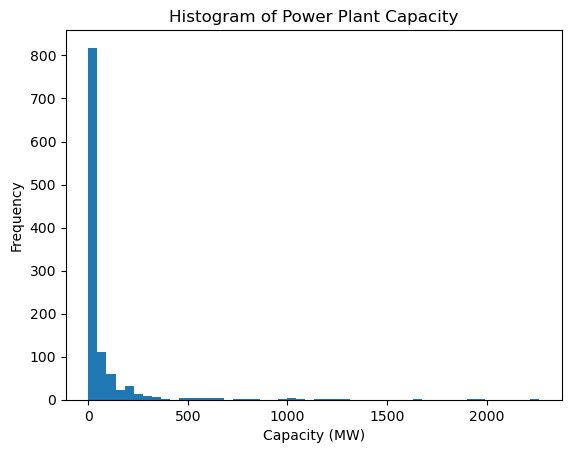

In [45]:
import matplotlib.pyplot as plt

plt.hist(ads_unmatched['maxcap(mw)'],bins=50)
plt.xlabel('Capacity (MW)')
plt.ylabel('Frequency')
plt.title('Histogram of Power Plant Capacity')
plt.show()


### Final HotFixes and Exporting

In [46]:
# Hot fix for mis-labeled wind plant 
ads_thermal_locs.loc[ads_thermal_locs.ads_name == 'Voyager Wind 1_3','fueltype'] = 'Wind'
ads_thermal_locs.loc[ads_thermal_locs.ads_name == 'Dracker Solar Unit 3 BESS','fueltype'] = 'battery'
ads_thermal_locs.loc[ads_thermal_locs.ads_name == 'Taos Mesa Storage','fueltype'] = 'battery'
ads_thermal_locs.fueltype.unique()

array(['Solar', 'NG', 'Water', 'Bio', 'Wind', 'WH', 'Geo', 'Uranium',
       'Petroleum Coke', nan, 'Coal', 'NatGas', 'Oil', 'Electricity',
       'Natural Gas', 'Subbituminous Coal', 'Combined Cycle', 'MWH',
       'Nuclear', 'Landfill Gas', 'battery', 'DFO', 'OBG', 'WDS',
       'Biomass Waste', 'LFG'], dtype=object)

In [47]:
ads_plants_locs = pd.concat([ads_thermal_locs, ads_unmatched])
ads_plants_locs.to_csv('../../repo_data/ads_plants_locs.csv', index=False)
ads_plants_locs

,generatorkey,ads_name,bus id,bus name,bus kv,unit id,generator typeid,subtype,long id,ads_long_name,...,IncHR4(MMBTu/MWh),IncCap5(MW),IncHR5(MMBTu/MWh),IncCap6(MW),IncHR6(MMBTu/MWh),IncCap7(MW),IncHR7(MMBTu/MWh),plant_id_eia,lat,lon
0,40,Hatch_Solar_EC,11404,HAT_DIST_PV,0.69,'PV,4,SolarPV-Tracking,NM-57591-1,"Hatch Solar Energy Center I, LLC-1",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57591.0,32.630000,-107.259700
1,45,Copper_1,11051,COPPER_G,13.80,'1,1,CT-NatGas-Industrial,TX-9-1,Copper-1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,31.756900,-106.375000
2,54,Montana_4_G4,11233,MPS4,13.80,'1,1,CT-NatGas-Aero,TX-58562-GT-4,Montana 4-G4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,31.823889,-106.211944
3,55,Montana_3_G3,11232,MPS3,13.80,'1,1,CT-NatGas-Aero,TX-58562-GT-3,Montana 3-G3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,31.823889,-106.211944
4,56,Montana_2_G2,11228,MPS2,13.80,'1,1,CT-NatGas-Aero,TX-58562-GT-2,Montana 2-G2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,31.823889,-106.211944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2542,15778,DR_PACW,44522,COLUMBIA,69.00,'DR,4,DR,nan,PACW Demand Response,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4301,18643,DG-BTM_BPAT_OR_Harney,47146,CRANE_HEC,115.00,'U1,4,DG-BTM,G0--,DG-BTM_BPAT_OR_Harney,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4292,18634,DG-BTM_BPAT_NV_Humboldt,47167,FIELDS_HEC,115.00,'V0,4,DG-BTM,G0--,DG-BTM_BPAT_NV_Humboldt,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1565,12961,DR_NEVP-1,18027,TORTISE,230.00,'DR,4,DR,NV--,NEVP Demand Response (1of8),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


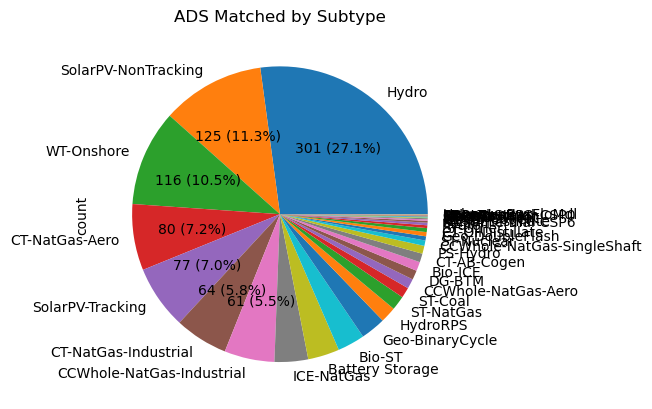

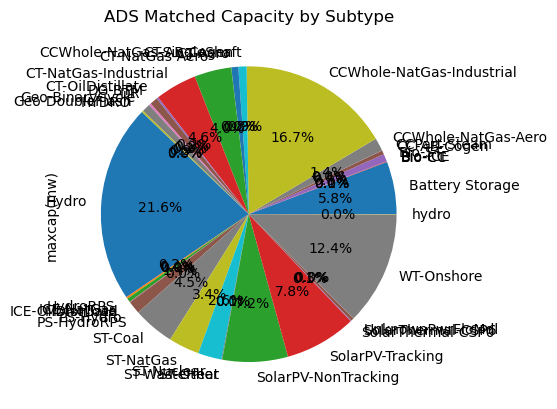

In [48]:
import matplotlib.pyplot as plt

# First pie chart
subtype_counts = ads_thermal_locs['subtype'].value_counts()
subtype_counts.plot(kind='pie', autopct=lambda x: f'{int(x/100 * len(ads_unmatched))} ({x:.1f}%)' if x/100 * len(ads_unmatched) > 50 else '')
plt.title('ADS Matched by Subtype')
plt.show()


# Pie chart of maxcap(mw) of each subtype of plant
subtype_maxcap = ads_thermal_locs.groupby('subtype')['maxcap(mw)'].sum()
subtype_maxcap.plot(kind='pie', autopct='%1.1f%%')
plt.title('ADS Matched Capacity by Subtype')
plt.show()


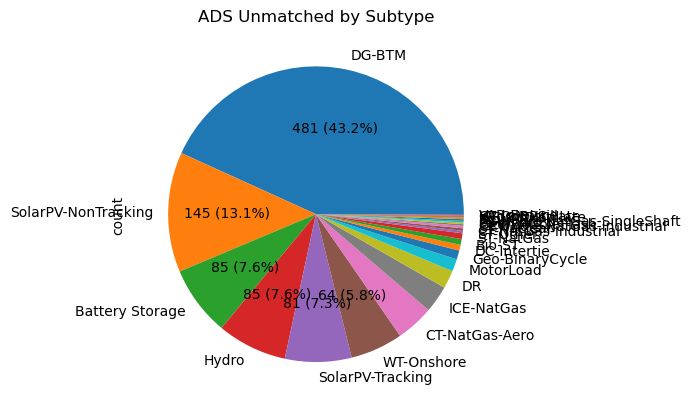

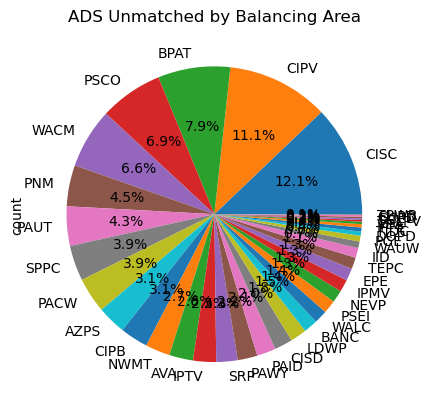

In [49]:
import matplotlib.pyplot as plt

# First pie chart
subtype_counts = ads_unmatched['subtype'].value_counts()
subtype_counts.plot(kind='pie', autopct=lambda x: f'{int(x/100 * len(ads_unmatched))} ({x:.1f}%)' if x/100 * len(ads_unmatched) > 50 else '')
plt.title('ADS Unmatched by Subtype')
plt.show()

# Second pie chart
ba_counts = ads_unmatched['balancing_area'].value_counts()
ba_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('ADS Unmatched by Balancing Area')
plt.show()


In [50]:
#filter subtype dg-btm
filt = ['DG-BTM']
ads_unmatched[~ads_unmatched['subtype'].isin(filt)]

,generatorkey,ads_name,bus id,bus name,bus kv,unit id,generator typeid,subtype,long id,ads_long_name,...,IncCap3(MW),IncHR3(MMBTu/MWh),IncCap4(MW),IncHR4(MMBTu/MWh),IncCap5(MW),IncHR5(MMBTu/MWh),IncCap6(MW),IncHR6(MMBTu/MWh),IncCap7(MW),IncHR7(MMBTu/MWh)
3476,17740,Battery (Generic)BA1645.24,25559,RP_WW230_2G,0.55,'VE,3,Battery Storage,_,34.196505_-118.931898,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3518,17791,Tehachapi_Solar (Generic)PV-NT1277,25378,RP_WW_2G,0.69,'VS,4,SolarPV-NonTracking,_,Iron Point -Proposed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3522,17795,Tehachapi_Solar (Generic)PV-NT1247,25563,RP_ANT_AG,0.55,'VS,4,SolarPV-NonTracking,_,Iron Point -Proposed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3517,17790,Tehachapi_Solar (Generic)PV-NT1153,25369,RP_WNDHBA_G,0.55,'VS,4,SolarPV-NonTracking,_,Iron Point -Proposed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3236,17481,Wyoming_Wind (Generic),25454,RP_ELDRO_1G,0.39,'VW,4,WT-Onshore,_,ADS2032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571,13009,DR_SPPC-1,64069,MACHACEK,230.00,'DR,4,DR,NV--,SPPC Demand Response (1of4),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1570,12998,DR_PSEI-01,41322,TANNER,115.00,'DR,4,DR,WA--,PSEI Demand Response (1of11),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2542,15778,DR_PACW,44522,COLUMBIA,69.00,'DR,4,DR,nan,PACW Demand Response,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1565,12961,DR_NEVP-1,18027,TORTISE,230.00,'DR,4,DR,NV--,NEVP Demand Response (1of8),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
